## Import Libraries

In [1]:
# data wrangling and exploration
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()

## Data Wrangling

In [2]:
# import data
crime_df = pd.read_csv('../data/crime-log-geocode-raw.csv')

In [3]:
# check for null values
crime_df.isnull().sum()

case_number              0
time_reported            0
time_started             0
time_ended               0
location_of_occurence    0
domestic_relationship    0
incident_type            0
criminal_offense         0
disposition              0
latitude                 0
longitude                0
dtype: int64

In [4]:
# check for duplicate values
crime_df.duplicated().sum()

5672

In [5]:
# drop duplicates
crime_df = crime_df.drop_duplicates()

# drop "DRAWN IN ERROR" values
crime_df = crime_df.drop(crime_df[crime_df.incident_type == "DRAWN IN ERROR"].index)

# drop "OFFICE INFORMATION" incidents
crime_df = crime_df.drop(crime_df[crime_df.incident_type == "OFFICE INFORMATION (MUPD)"].index)

# reset index after dropping duplicates
crime_df = crime_df.reset_index(drop=True)

In [6]:
# check data types for each columns
crime_df.dtypes

case_number                int64
time_reported             object
time_started              object
time_ended                object
location_of_occurence     object
domestic_relationship     object
incident_type             object
criminal_offense          object
disposition               object
latitude                 float64
longitude                float64
dtype: object

In [7]:
# convert date columns to datetime
crime_df.time_reported = pd.to_datetime(crime_df.time_reported)
crime_df.time_started = pd.to_datetime(crime_df.time_started)
crime_df.time_ended = pd.to_datetime(crime_df.time_ended)

## Explore the Data

### Criminal Offenses

We can see from the first 20 rows of data that there are several larcenies and assaults each with their own subcategories. Let's check the value counts. It might be better to lump all assaults into one category instead of having multiple subcategories. For example, instead of "ASSAULT - SIMPLE", change it to just "ASSAULT".

In [8]:
crime_df.head(20)

,case_number,time_reported,time_started,time_ended,location_of_occurence,domestic_relationship,incident_type,criminal_offense,disposition,latitude,longitude
0,202300548,2023-04-24 16:56:00,2023-04-24 16:56:00,2023-04-24 16:56:00,"907 HITT ST, COLUMBIA MO, 65201",NO,PROPERTY DAMAGE,PROPERTY DAMAGE,ACTIVE,38.939613,-9.232680e+01
1,202300545,2023-04-23 18:26:00,2023-04-23 18:26:00,2023-04-23 18:26:00,"904 ELM STREET, COLUMBIA MO, 65211",NO,HARASSMENT,HARASSMENT,ACTIVE,38.948217,-9.232689e+01
2,202300544,2023-04-23 10:08:08,2023-04-23 08:08:41,2023-04-23 10:08:08,"1 HOSPITAL DR, COLUMBIA MO, 65201",NO,ASSAULT-SIMPLE,ASSAULT-SIMPLE,CLEARED BY ARREST,38.938273,-9.232738e+01
3,202300544,2023-04-23 10:08:08,2023-04-23 08:08:41,2023-04-23 10:08:08,"1 HOSPITAL DR, COLUMBIA MO, 65201",NO,OTHER OFFENSE - NOT REPORTABLE,ASSAULT-SIMPLE,CLEARED BY ARREST,38.938273,-9.232738e+01
4,202300542,2023-04-22 23:55:00,2023-04-22 23:55:00,2023-04-22 23:55:00,"399 E STADIUM BLVD, COLUMBIA MO, 65203",NO,TRAFFIC OFFENSE,TRAFFIC OFFENSE,CLEARED BY ARREST,38.938349,-9.233316e+01
5,202300542,2023-04-22 23:55:00,2023-04-22 23:55:00,2023-04-22 23:55:00,"399 E STADIUM BLVD, COLUMBIA MO, 65203",NO,WARRANT ARREST,TRAFFIC OFFENSE,CLEARED BY ARREST,38.938349,-9.233316e+01
6,202300541,2023-04-22 21:18:00,2023-04-22 21:18:00,2023-04-22 21:18:00,"1 HOSPITAL DRIVE, COLUMBIA MO, 65201",NO,ASSAULT-SIMPLE,ASSAULT-SIMPLE,CLEARED BY ARREST,38.938273,-9.232738e+01
7,202300540,2023-04-22 10:23:00,2023-04-22 10:23:00,2023-04-22 10:23:00,"1 HOSPITAL DR, COLUMBIA MO, 65201",NO,LARCENY - SHOPLIFTING,LARCENY - SHOPLIFTING,EXCEPTIONALLY CLEARED,38.938273,-9.232738e+01
8,202300539,2023-04-22 07:22:00,2023-04-22 07:22:00,2023-04-22 07:22:00,"115 MIZZOU NORTH, COLUMBIA MO, 65201",NO,LARCENY - THEFT FROM BUILDING,LARCENY - THEFT FROM BUILDING,ACTIVE,38.967138,-9.233914e+01
9,202300538,2023-04-22 01:06:00,2023-04-22 01:06:00,2023-04-22 01:06:00,"949 CONLEY AVE, COLUMBIA MO, 65201",NO,TRAFFIC OFFENSE,TRAFFIC OFFENSE,CLEARED BY ARREST,0.168257,9.087286e+07


In [9]:
# value count for criminal_offense
crime_df.criminal_offense.value_counts().head(10)

FORGERY                     1441
DRUG - NARCOTIC             1273
TRAFFIC OFFENSE              567
LIQUOR LAW                   539
DWI                          533
ASSAULT-SIMPLE               428
CRASH INVESTIGATION          425
LARCENY - OTHER              412
PROPERTY DAMAGE              392
SICK/MENTALLY ILL PERSON     267
Name: criminal_offense, dtype: int64

I thought there would be more larceny offenses. What happens if we combine all subcategories of larceny into one large category? Let's do the same for other criminal offenses as well. We can keep the original column for more detail and create a new column for the general category.

In [10]:
# check number of larceny incidents
crime_df.query('criminal_offense.str.contains("LARCENY")').shape

(853, 11)

As you can see, if we filter the dataframe for all offenses that are larceny, it returns 853 incidents. In the original value count, this would have made it a top 3 crime. Let's go ahead and put all incidents into their respective general categories and check the results.

NameError: name 'temp_df' is not defined

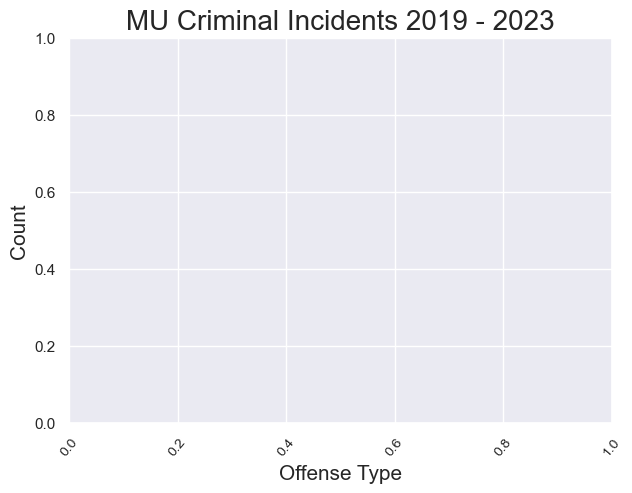

In [11]:
# create new column of a generalization of criminal offenses
crime_df['general_offense'] = crime_df.criminal_offense.str.replace(r'-.*', '', regex=True)

# plot top 10 criminal incidents
plt.figure(figsize=(7, 5))
plt.title('MU Criminal Incidents 2019 - 2023', fontsize=20)
plt.xticks(rotation=50, fontsize=10)
plt.xlabel('Offense Type', fontsize=15)
plt.ylabel('Count', fontsize=15)
sns.barplot(x=temp_df.index, y=temp_df.values)

plt.show()




### Criminal Activity Locations

In [ ]:
# value count for location
crime_df.location_of_occurence.value_counts().head(10)

A lot of incidents occuring near the hospital. Including "901 Virginia Ave", that is almost 20% of incidents happening near the hospital. It might be worth exploring the types of activities just in that area as compared to all the data.

In [ ]:
# Create a Plotly Express figure with a scatter_mapbox trace and a density_mapbox layer

# px.set_mapbox_access_token('your_mapbox_access_token')

fig = px.density_mapbox(
    crime_df,
    lat='latitude',
    lon='longitude',
    radius=15,  # Adjust the radius to control the level of aggregation
    center=dict(lat=38.94244, lon=-92.3269),  # Set the center coordinates of the map
    zoom=15,  # Set the initial zoom level
    mapbox_style='open-street-map',
    hover_name='location_of_occurence',  # Optional: Set a column to show when hovering over points
        color_continuous_scale=px.colors.plotlyjs.Blackbody,  # Choose the color scale
)

fig.update_layout(width=800, height=600)

fig.show()


In [ ]:
temp_df = crime_df.groupby(['latitude', 'longitude', 'location_of_occurence'], as_index=False).size().sort_values(by='size', ascending=False)